**Pneumonia Detection in Chest X-rays using InceptionV3 and Grad-CAM**

Pneumonia is a serious respiratory condition that can cause significant morbidity and mortality, especially in children, the elderly, and immunocompromised individuals. Early and accurate diagnosis is essential for effective treatment. Chest X-rays are one of the most commonly used tools for diagnosing pneumonia, but manual interpretation can be subjective and prone to human error, especially in high-volume clinical settings.

In this project, we aim to develop a deep learning-based model that can automatically classify chest X-ray images as either NORMAL or PNEUMONIA. To achieve this, we utilize the InceptionV3 convolutional neural network, a powerful pre-trained model known for its high performance on image classification tasks. We fine-tune this model on a labeled dataset of chest X-rays to specialize it for pneumonia detection.

By combining transfer learning with interpretability techniques, this project not only builds a robust pneumonia classifier but also provides insights into how and where the model is making its decisions. This is an important step toward building AI tools that are both accurate and trustworthy in real-world medical applications.

**Imports**

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

**Loading Data**

The Chest X-ray Pneumonia Dataset (Kaggle v3) is provided by the National Institutes of Health (NIH) in collaboration with academic partners. It contains a total of 5,856 chest X-ray images in JPEG format, which are categorized into NORMAL (chest X-rays with no signs of pneumonia) and PNEUMONIA (chest X-rays showing signs of infection, further labeled as bacterial or viral, but treated as a single PNEUMONIA class for this project). The images were collected from pediatric patients aged 1–5 years at the Guangzhou Women and Children’s Medical Center in China. The dataset is originally split into train/, val/, and test/ folders, and the images vary in size but are resized to 224×224 pixels for this project. This dataset is widely used for benchmarking deep learning models on medical image classification, particularly for pneumonia detection tasks using convolutional neural networks.


In [19]:
dataset_path = '/kaggle/input/chest-xray-pneumonia'

base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'

train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
valid_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

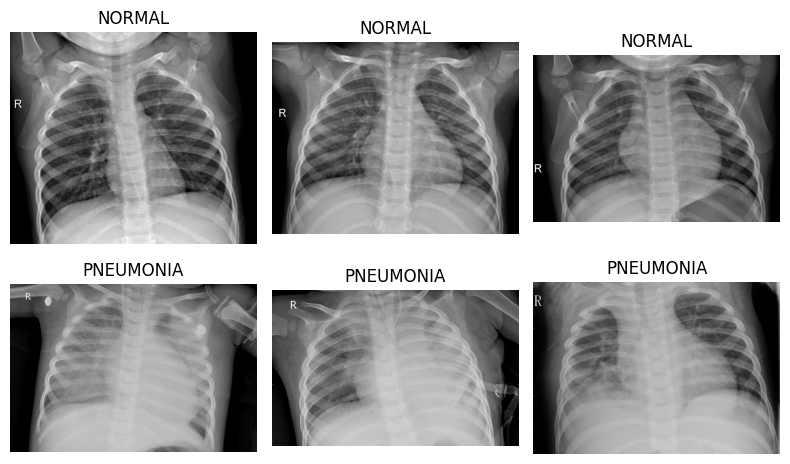

In [8]:

normal_path = os.path.join(train_dir, "NORMAL")
pneumonia_path = os.path.join(train_dir, "PNEUMONIA")


normal_images = random.sample(os.listdir(normal_path), 3)
pneumonia_images = random.sample(os.listdir(pneumonia_path), 3)


plt.figure(figsize=(8,5))

for i, img_name in enumerate(normal_images):
    img = mpimg.imread(os.path.join(normal_path, img_name))
    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title("NORMAL")
    plt.axis('off')

for i, img_name in enumerate(pneumonia_images):
    img = mpimg.imread(os.path.join(pneumonia_path, img_name))
    plt.subplot(2, 3, i+4)
    plt.imshow(img, cmap='gray')
    plt.title("PNEUMONIA")
    plt.axis('off')

plt.tight_layout()
plt.show()


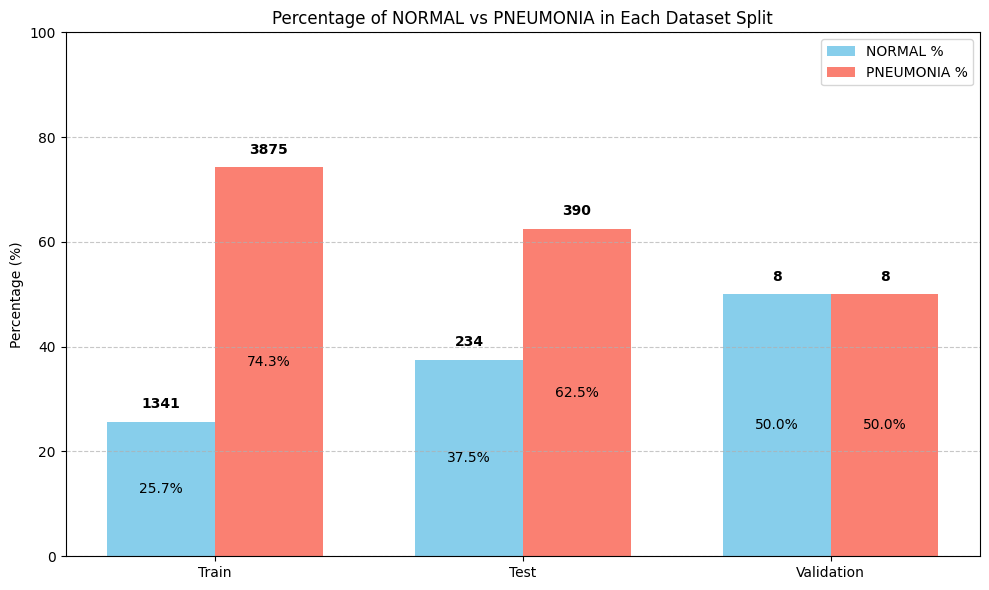

In [15]:
categories = ['Train', 'Test', 'Validation']
normal_counts = [train_normal, test_normal, val_normal]
pneumonia_counts = [train_pneumonia, test_pneumonia, val_pneumonia]

percent_normal = [n / (n + p) * 100 for n, p in zip(normal_counts, pneumonia_counts)]
percent_pneumonia = [p / (n + p) * 100 for n, p in zip(normal_counts, pneumonia_counts)]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
bars_normal = ax.bar(x - width/2, percent_normal, width, label='NORMAL %', color='skyblue')
bars_pneumonia = ax.bar(x + width/2, percent_pneumonia, width, label='PNEUMONIA %', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Percentage (%)')
ax.set_title('Percentage of NORMAL vs PNEUMONIA in Each Dataset Split')
ax.set_ylim(0, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i in range(len(categories)):
    ax.text(x[i] - width/2, percent_normal[i] + 2, f'{normal_counts[i]}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.text(x[i] - width/2, percent_normal[i] / 2, f'{percent_normal[i]:.1f}%', ha='center', va='center', fontsize=10, color='black')
    
    ax.text(x[i] + width/2, percent_pneumonia[i] + 2, f'{pneumonia_counts[i]}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.text(x[i] + width/2, percent_pneumonia[i] / 2, f'{percent_pneumonia[i]:.1f}%', ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()




*To ensure a fair and balanced evaluation of my model, I decided to custom split the dataset instead of relying on the original train, test, and validation folders provided. The original validation set contained only 16 images, which is far too small for proper model evaluation.* 

*Additionally, the class distribution (NORMAL vs PNEUMONIA) varied significantly across the sets, which could affect training and result accuracy.*




In [23]:
base_path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
random.seed(10)  

all_image_paths = defaultdict(list)
for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(base_path, split, cls)
        all_image_paths[cls].extend(glob.glob(os.path.join(folder, '*.jpeg')))

def split_data(file_list, train_ratio=0.7, val_ratio=0.15):
    random.shuffle(file_list)
    n = len(file_list)
    train = file_list[:int(train_ratio * n)]
    val = file_list[int(train_ratio * n):int((train_ratio + val_ratio) * n)]
    test = file_list[int((train_ratio + val_ratio) * n):]
    return train, val, test


train_paths = []
val_paths = []
test_paths = []

for cls in ['NORMAL', 'PNEUMONIA']:
    train, val, test = split_data(all_image_paths[cls])
    train_paths.extend([(p, cls) for p in train])
    val_paths.extend([(p, cls) for p in val])
    test_paths.extend([(p, cls) for p in test])

print(f"Train  - Total: {len(train_paths)}, NORMAL: {sum(1 for p in train_paths if p[1]=='NORMAL')}, PNEUMONIA: {sum(1 for p in train_paths if p[1]=='PNEUMONIA')}")
print(f"Val    - Total: {len(val_paths)}, NORMAL: {sum(1 for p in val_paths if p[1]=='NORMAL')}, PNEUMONIA: {sum(1 for p in val_paths if p[1]=='PNEUMONIA')}")
print(f"Test   - Total: {len(test_paths)}, NORMAL: {sum(1 for p in test_paths if p[1]=='NORMAL')}, PNEUMONIA: {sum(1 for p in test_paths if p[1]=='PNEUMONIA')}")



Train  - Total: 4099, NORMAL: 1108, PNEUMONIA: 2991
Val    - Total: 878, NORMAL: 237, PNEUMONIA: 641
Test   - Total: 879, NORMAL: 238, PNEUMONIA: 641


**CUSTOM SPLIT**


*I collected all images from the original train, test, and val folders.Then, I created a custom split using the ratio:*


* 70% for training

* 15% for validation

* 15% for testing

*I performed the split separately for each class (NORMAL and PNEUMONIA) to preserve the original class proportions.*

Final Dataset Summary:
 Total images: 5,856
 
 Overall class ratio:

* NORMAL: ~27%
* PNEUMONIA: ~73%



*These ratios are now preserved in all three subsets: training, validation, and test.This custom split gives me more control over the dataset and helps ensure that the model will generalize better across unseen data.*




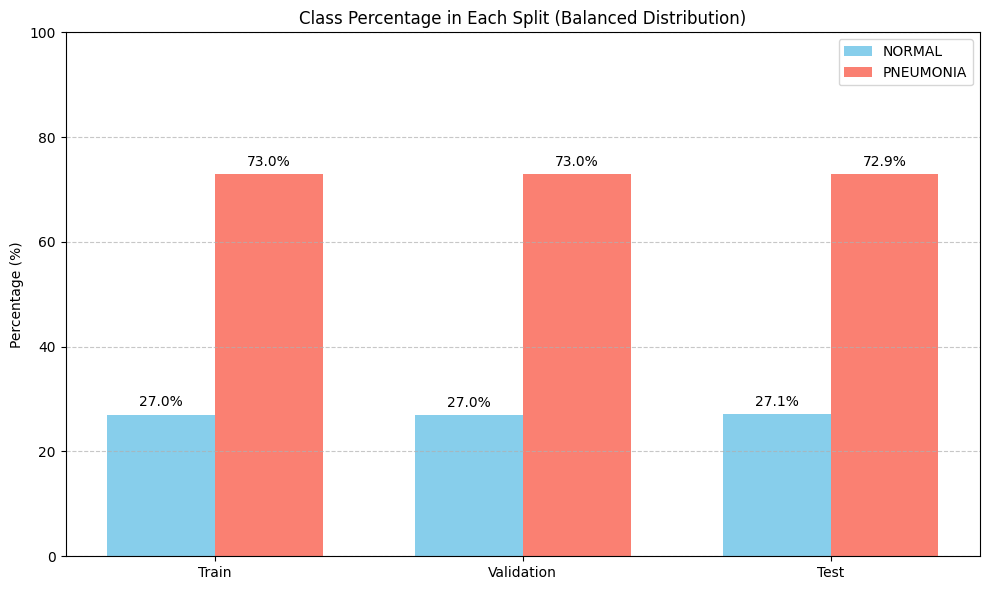

In [25]:
def count_by_class(image_list):
    normal = sum(1 for p in image_list if p[1] == 'NORMAL')
    pneumonia = sum(1 for p in image_list if p[1] == 'PNEUMONIA')
    return normal, pneumonia

train_normal, train_pneumonia = count_by_class(train_paths)
val_normal, val_pneumonia = count_by_class(val_paths)
test_normal, test_pneumonia = count_by_class(test_paths)

train_total = train_normal + train_pneumonia
val_total = val_normal + val_pneumonia
test_total = test_normal + test_pneumonia

categories = ['Train', 'Validation', 'Test']
normal_percent = [
    train_normal / train_total * 100,
    val_normal / val_total * 100,
    test_normal / test_total * 100
]
pneumonia_percent = [
    train_pneumonia / train_total * 100,
    val_pneumonia / val_total * 100,
    test_pneumonia / test_total * 100
]

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, normal_percent, width, label='NORMAL', color='skyblue')
bars2 = plt.bar(x + width/2, pneumonia_percent, width, label='PNEUMONIA', color='salmon')

for i in range(len(categories)):
    plt.text(x[i] - width/2, normal_percent[i] + 1, f'{normal_percent[i]:.1f}%', ha='center', va='bottom')
    plt.text(x[i] + width/2, pneumonia_percent[i] + 1, f'{pneumonia_percent[i]:.1f}%', ha='center', va='bottom')

plt.xticks(x, categories)
plt.ylim(0, 100)
plt.ylabel('Percentage (%)')
plt.title('Class Percentage in Each Split (Balanced Distribution)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Custom Data Generator**

This class (ChestXrayGenerator) helps load and preprocess chest X-ray images in batches during training.

It resizes images to 224×224 and normalizes pixel values.

Labels are converted to 0 (NORMAL) or 1 (PNEUMONIA).

It also supports shuffling the data after each epoch.

In [26]:
class ChestXrayGenerator(Sequence):
    def __init__(self, image_label_list, batch_size=32, image_size=(224, 224), shuffle=True, augment=False):
        self.image_label_list = image_label_list
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_label_list) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_label_list)
    
    def __getitem__(self, index):
        batch_items = self.image_label_list[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        labels = []
        
        for img_path, label in batch_items:
            img = load_img(img_path, target_size=self.image_size)
            img = img_to_array(img) / 255.0  
            images.append(img)
            
            labels.append(0 if label == 'NORMAL' else 1)
        
        return np.array(images), np.array(labels)


**InceptionV3**


*InceptionV3 is a powerful convolutional neural network architecture developed by Google, known for its efficiency and high performance in image classification tasks. Unlike traditional CNNs that stack layers sequentially, InceptionV3 uses Inception modules that process input through multiple parallel convolutional filters of different sizes (like 1x1, 3x3, and 5x5), enabling it to capture both fine and coarse features effectively. It also employs techniques like factorized convolutions (breaking larger convolutions into smaller ones), batch normalization, and auxiliary classifiers, which help improve training speed, reduce computational cost, and address issues like vanishing gradients. Pretrained on the large-scale ImageNet dataset, InceptionV3 serves as a popular backbone for transfer learning in various computer vision problems.*

I use InceptionV3, a powerful pre-trained CNN, as the base for our pneumonia detection model.
It’s trained on ImageNet and helps extract high-level image features.
i load it without the top layers (i.e., no classifier).
For now, I freeze its weights so only our custom layers will train initially.

In [27]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x) 
model = Model(inputs=base_model.input, outputs=predictions)


In [30]:


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


**Training**

In [34]:
train_gen = ChestXrayGenerator(train_paths, batch_size=32, augment=True)
val_gen = ChestXrayGenerator(val_paths, batch_size=32, augment=False)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - accuracy: 0.9377 - loss: 0.1653 - val_accuracy: 0.9465 - val_loss: 0.1469
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 330ms/step - accuracy: 0.9325 - loss: 0.1668 - val_accuracy: 0.9544 - val_loss: 0.1398
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 333ms/step - accuracy: 0.9314 - loss: 0.1742 - val_accuracy: 0.9544 - val_loss: 0.1369
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 333ms/step - accuracy: 0.9312 - loss: 0.1796 - val_accuracy: 0.9533 - val_loss: 0.1348
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 330ms/step - accuracy: 0.9445 - loss: 0.1647 - val_accuracy: 0.9510 - val_loss: 0.1351
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 328ms/step - accuracy: 0.9406 - loss: 0.1569 - val_accuracy: 0.9510 - val_loss: 0.1337
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 327ms/step - accuracy: 0.9379 - loss: 0.1646 - val_accuracy: 0.9544 - val_loss: 0.1349
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 331ms/step - accuracy: 0.9430 - loss: 0

In [35]:
for layer in base_model.layers[-40:]:
    layer.trainable = True


In [37]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


***Train with fine-tuning***

In [38]:
 fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10, 
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 80s 467ms/step - accuracy: 0.9160 - loss: 0.1958 - val_accuracy: 0.9567 - val_loss: 0.1263
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 326ms/step - accuracy: 0.9471 - loss: 0.1480 - val_accuracy: 0.9556 - val_loss: 0.1183
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 332ms/step - accuracy: 0.9563 - loss: 0.1231 - val_accuracy: 0.9579 - val_loss: 0.1157
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 330ms/step - accuracy: 0.9686 - loss: 0.0983 - val_accuracy: 0.9579 - val_loss: 0.1133
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 328ms/step - accuracy: 0.9665 - loss: 0.0883 - val_accuracy: 0.9567 - val_loss: 0.1111
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 329ms/step - accuracy: 0.9791 - loss: 0.0755 - val_accuracy: 0.9533 - val_loss: 0.1068
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 44s 327ms/step - accuracy: 0.9815 - loss: 0.0655 - val_accuracy: 0.9567 - val_loss: 0.1064
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 45s 331ms/step - accuracy: 0.9842 - loss: 0

In [39]:
test_gen = ChestXrayGenerator(test_paths, batch_size=32, augment=False, shuffle=False)


In [40]:
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 655ms/step - accuracy: 0.9196 - loss: 0.2157
Test Accuracy: 0.9454
Test Loss: 0.1425


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step


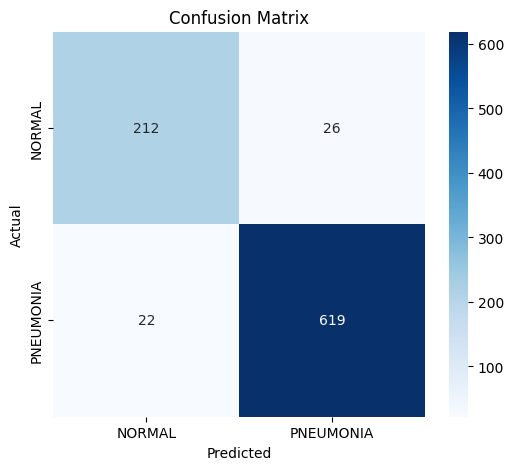

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.89      0.90       238
   PNEUMONIA       0.96      0.97      0.96       641

    accuracy                           0.95       879
   macro avg       0.93      0.93      0.93       879
weighted avg       0.95      0.95      0.95       879



In [41]:
test_gen = ChestXrayGenerator(test_paths, batch_size=32, augment=False, shuffle=False)

y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()  # Convert to binary (0 or 1)

y_true = np.array([0 if label == 'NORMAL' else 1 for _, label in test_paths])

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))


**Classification Report Analysis:**

 Overall Performance:
 
Accuracy: 95% → The model correctly predicted 95% of test samples.

Macro Avg: 0.93 → Average performance across both classes, treating each equally.

Weighted Avg: 0.95 → Adjusts for class imbalance; confirms overall strong reliability.

The classification report reveals that the model performs exceptionally well on the test set, achieving an overall accuracy of 95%. It shows particularly strong performance in identifying pneumonia, with both precision and recall close to 97%, meaning the model is highly effective in detecting actual pneumonia cases and makes very few incorrect pneumonia predictions. NORMAL class performance is slightly lower but still strong, with an F1-score of 0.90. The macro and weighted averages reinforce the model’s consistency across classes. These results suggest that the model is well-suited for reliable pneumonia detection in chest X-ray images.

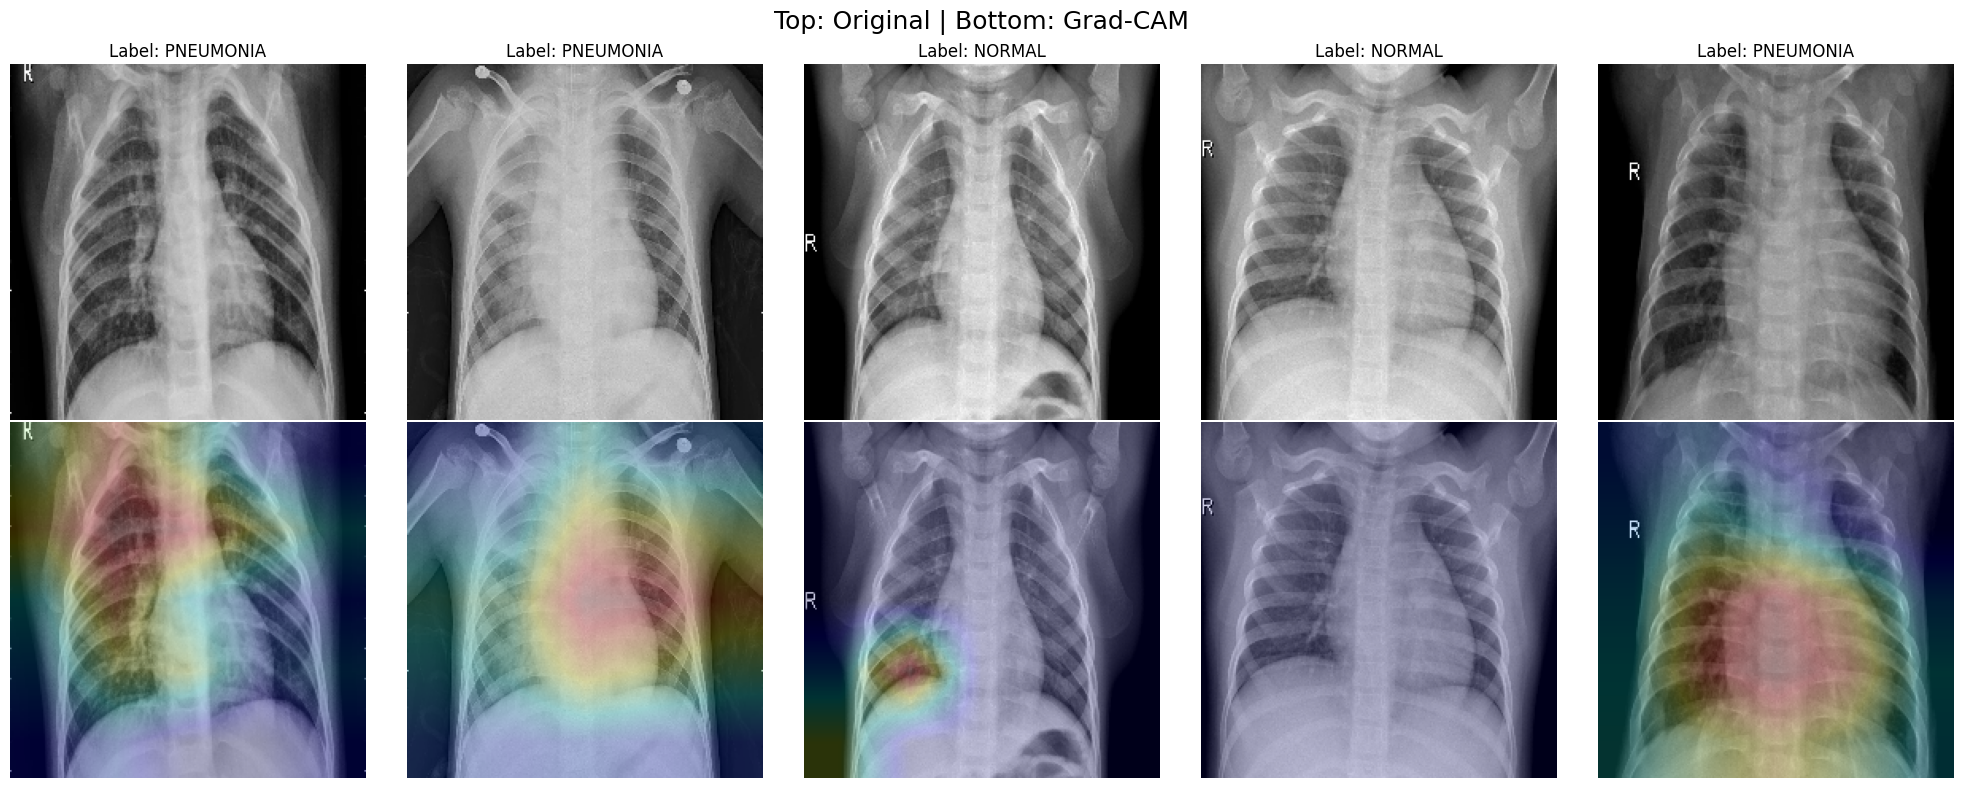

In [54]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap, alpha=0.2):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)
    return superimposed_img

test_images = random.sample(test_paths, 5)


fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Top: Original | Bottom: Grad-CAM", fontsize=18)

for i, (img_path, label) in enumerate(test_images):
    img = load_img(img_path, target_size=(224, 224))
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Label: {label}")

    # Grad-CAM heatmap
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='mixed10')
    superimposed = overlay_heatmap(img_path, heatmap, alpha=0.2)

    axes[1, i].imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


 **Grad-CAM Visual Explanations**
 
In the figures below, we use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize where the model is focusing when making its predictions.

We present two rows:

Row 1: Original Chest X-ray images from the test set.

Row 2: Grad-CAM heatmaps overlaid on the same images to highlight the regions most important to the model.

How to Interpret the Heatmaps

Red/Yellow regions indicate the areas the model considered most important for making a classification.

Faint or transparent areas indicate less attention from the model.


In PNEUMONIA-labeled images, we typically see strong activations (warm colors) in the lung areas, particularly where opacities or consolidations might exist. This suggests the model has learned to detect abnormal patterns consistent with pneumonia.

🫗 In NORMAL-labeled images, the model shows little or no activation, implying it found no abnormalities to focus on — just as we’d expect.

Grad-CAM helps us trust and understand the model’s predictions. It shows where the model is "looking," which aligns closely with clinical intuition — for instance, a radiologist would also focus on dense or patchy areas in the lungs when diagnosing pneumonia.
